In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random

# Project specific imports
import config # Your project's config file
from models import SimpleRewardEstimator # Your model definition
from importnb import Notebook

# Import the specific dataset used for reward training
with Notebook():
    from reward_dataset import RewardDatasetSingleFrame
    from jetbot_dataset import JetbotDataset, split_train_test_by_session_id # Import main dataset and session split

print(f"Using device: {config.DEVICE}")

Using device: cuda


In [2]:
# --- Configuration (from config.py and reward_estimator_training.ipynb) ---
REWARD_MODEL_OUTPUT_DIR = os.path.join(config.OUTPUT_DIR, 'reward_estimator')
REWARD_CHECKPOINT_FILENAME = "reward_estimator_best.pth" # File saved during training
BEST_MODEL_PATH = os.path.join(REWARD_MODEL_OUTPUT_DIR, REWARD_CHECKPOINT_FILENAME)

IMAGE_SIZE = config.IMAGE_SIZE
MAIN_CSV_PATH = config.CSV_PATH
MAIN_DATA_DIR = config.DATA_DIR
TRANSFORM = config.TRANSFORM
SEQUENCE_LENGTH = config.NUM_PREV_FRAMES # For JetbotDataset



In [3]:
def show_reward_predictions(model, samples_list, device, title_prefix=""):
    """
    Displays images from a provided list of image tensors and their predicted rewards.

    Args:
        model: The trained reward estimator model.
        samples_list: A list where each element is EITHER:
                      - a torch.Tensor (the image tensor)
                      - a tuple where the first element is the image tensor.
        device: The torch device ('cuda' or 'cpu').
        title_prefix: String to prepend to the plot title.
    """
    if not samples_list:
        print(f"Cannot show predictions: The provided samples list '{title_prefix}' is empty.")
        return

    num_samples = len(samples_list)
    print(f"\n--- {title_prefix} Example Predictions ({num_samples} specific samples) ---")

    plt.figure(figsize=(15, 5 * num_samples))
    model.eval() # Ensure model is in eval mode

    for i, item in enumerate(samples_list):
        img_tensor = None
        # Extract image tensor, whether item is the tensor itself or a tuple containing it
        if isinstance(item, torch.Tensor):
            img_tensor = item
        elif isinstance(item, tuple) and item and isinstance(item[0], torch.Tensor):
            img_tensor = item[0]
        else:
             print(f"Skipping sample {i}: Item is not a tensor or a tuple starting with a tensor.")
             continue

        # Predict for this single image
        img_tensor_batch = img_tensor.unsqueeze(0).to(device) # Add batch dim
        with torch.no_grad():
             predicted_reward = model(img_tensor_batch).item()

        # Prepare image for display (unnormalize)
        try:
            img_display = (img_tensor.cpu().clamp(-1, 1) + 1) / 2
            img_display = transforms.ToPILImage()(img_display)
        except Exception as e:
            print(f"Error processing image tensor for display at index {i}: {e}")
            continue

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_display)
        # Display only the predicted reward in the title
        plt.title(f"Predicted: {predicted_reward:.4f}")
        plt.axis('off')

    plt.suptitle(f"{title_prefix} Example Images and Predicted Rewards", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [4]:
# --- Load Model ---
print("\n--- Loading Reward Estimator Model ---")
reward_model = None
if os.path.exists(BEST_MODEL_PATH):
    try:
        reward_model = SimpleRewardEstimator() 
        reward_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=config.DEVICE))
        reward_model.to(config.DEVICE)
        reward_model.eval() # Set to evaluation mode
        print(f"Successfully loaded best model checkpoint from: {BEST_MODEL_PATH}")
        print(f"Model Parameters: {sum(p.numel() for p in reward_model.parameters() if p.requires_grad):,}")
    except Exception as e:
        print(f"Error loading model checkpoint from {BEST_MODEL_PATH}: {e}")
        reward_model = None
else:
    print(f"Error: Best model checkpoint not found at {BEST_MODEL_PATH}. Cannot run test.")



--- Loading Reward Estimator Model ---
Successfully loaded best model checkpoint from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\reward_estimator\reward_estimator_best.pth
Model Parameters: 422,401


In [5]:
print("\n--- Loading General Jetbot Dataset ---")
jetbot_dataset = None

try:
    jetbot_dataset = JetbotDataset(
        csv_path=MAIN_CSV_PATH, data_dir=MAIN_DATA_DIR, image_size=IMAGE_SIZE,
        num_prev_frames=SEQUENCE_LENGTH, transform=TRANSFORM, seed=42
    )
    print(f"Successfully loaded JetbotDataset with {len(jetbot_dataset.dataframe)} total rows "
          f"and {len(jetbot_dataset)} valid sequence starting points.")
except Exception as e:
    print(f"ERROR: Failed to instantiate JetbotDataset: {e}")
    jetbot_dataset = None


--- Loading General Jetbot Dataset ---
Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Successfully loaded JetbotDataset with 23081 total rows and 23037 valid sequence starting points.



--- Jetbot Dataset (General Navigation) Example Predictions (5 specific samples) ---


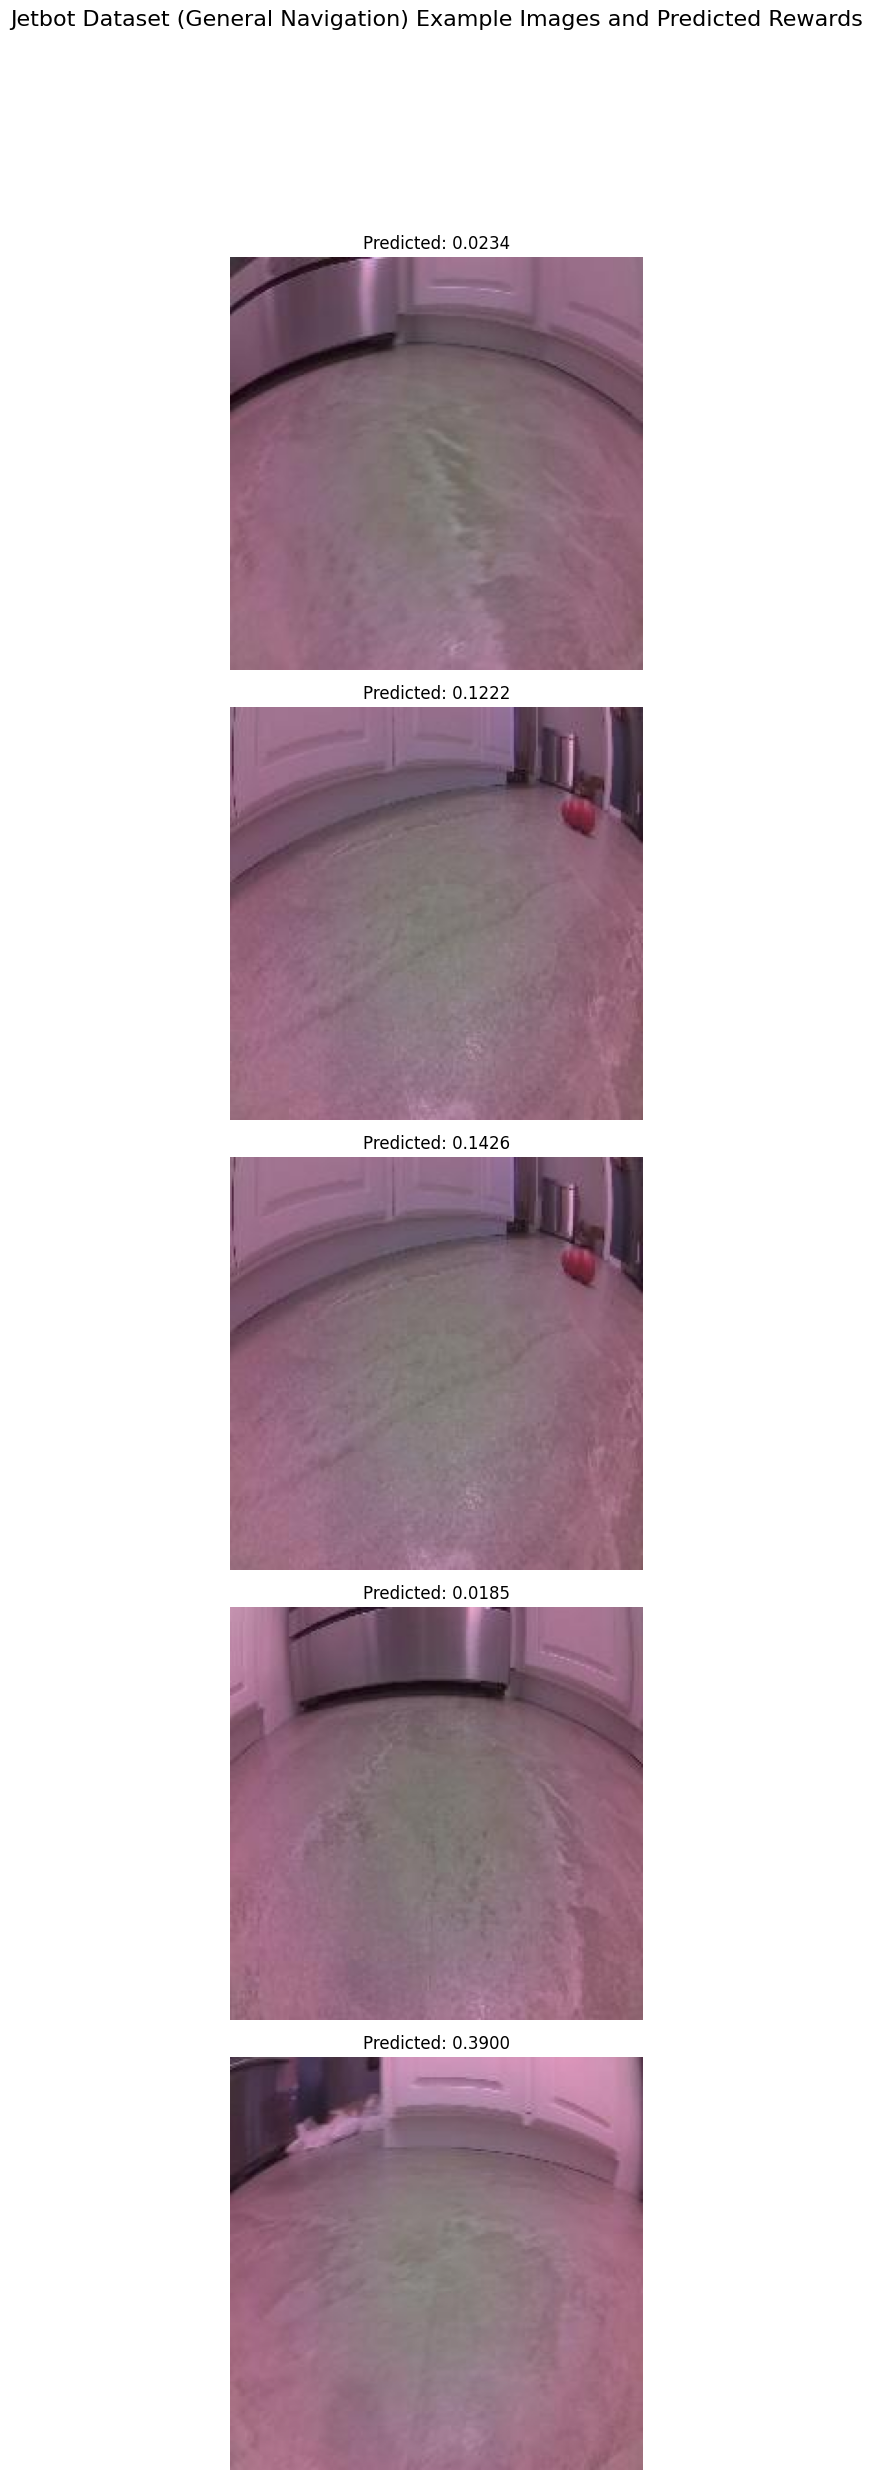

In [8]:
num_samples_to_show = 5
jetbot_samples_to_show = []
indices_to_get = random.sample(range(2000), num_samples_to_show)
# indices_to_get = random.sample(range(len(jetbot_dataset)), num_samples_to_show)

for i in indices_to_get:
    current_image, _, _ = jetbot_dataset[i] # Get the full sample
    jetbot_samples_to_show.append(current_image) # Append just the image tensor

show_reward_predictions(
    reward_model,
    samples_list=jetbot_samples_to_show, # Pass the list of images
    device=config.DEVICE,
    title_prefix="Jetbot Dataset (General Navigation)"
)

In [9]:
# --- Live camera + real-time reward estimation --------------------
# Place this cell AFTER you’ve imported torch, torchvision, PIL, etc.
# Adjust the two variables below for your setup ↓↓↓
JETBOT_IP       = "192.168.68.52"                                # <- your JetBot’s IP
REWARD_CKPT     = rf"{config.OUTPUT_DIR}\reward_estimator\reward_estimator_best.pth"

# ---------------------------------------------------------------
from jetbot_remote_client import RemoteJetBot                    # :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
from models import SimpleRewardEstimator                         # :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}
import ipywidgets as widgets, torch, cv2
from PIL import Image
import asyncio

# 1) Connect to the robot
jetbot = RemoteJetBot(JETBOT_IP)

# 2) Load the reward-estimator
device = config.DEVICE                                           # :contentReference[oaicite:4]{index=4}:contentReference[oaicite:5]{index=5}
reward_net = SimpleRewardEstimator().to(device)
reward_net.load_state_dict(torch.load(REWARD_CKPT, map_location=device))
reward_net.eval()

# 3) Extra widget for the reward value
reward_label = widgets.Label(value="Reward: ---")
display(reward_label)

transform = config.TRANSFORM                                     # same pre-processing as training

async def live_loop(refresh_hz=15):
    """Continuously grab a frame, estimate reward, update widgets."""
    while True:
        frame = jetbot.get_frame()           # ndarray (BGR) or None
        if frame is not None:
            # open-CV BGR → RGB → PIL → tensor
            rgb  = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil  = Image.fromarray(rgb)
            x    = transform(pil).unsqueeze(0).to(device)

            with torch.no_grad():
                r = reward_net(x).item()

            reward_label.value = f"Reward: {r:.3f}"
        await asyncio.sleep(1.0 / refresh_hz)

# 4) Kick off the async loop (runs until you interrupt the notebook)
await live_loop()


INFO:JetBotClient:Connecting to JetBot at 192.168.68.52:18861
INFO:JetBotClient:Connected successfully!


Image(value=b'', format='jpeg', height='300', width='400')

Label(value='Reward: ---')

CancelledError: 